<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Fastai%20NLP%20course/2_Topic_Modeling_with_NMF_and_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling with NMF and SVD



##The problem

Topic modeling is a fun way to start our study of NLP. We will use two popular matrix decomposition techniques.

We start with a **term-document matrix**. The idea is that we have collections of documents and text. So here, we have an example of showing of the plays of Shakespeare and we represent them as **bag of words**. Just kind of taking the word count of different words.

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/document_term.png)

source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#)

The idea behind matrix decomposition is taking one matrix and represent it as a few matrices, the one we look at these will be matrix products so we 'll take one matrix and decompose it into a few things that mutiply together that give you ordinal matrix.

The reason it is useful is the factors that you're decomposing into which have special property that are nicer than the original matrix.

We can decompose this into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between).

Notice that this representation does not take into account word order or sentence structure. It's an example of a bag of words approach.

Latent Semantic Analysis (LSA) uses Singular Value Decomposition (SVD).

## Motivation
Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. Clearly, in most cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count, and one with the average number of words per document, then that outer product would be as close as we can get.

Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster the documents into two groups, each of which has as different a distribution of words as possible to each other, but as similar as possible amongst the documents in the cluster. We will call those two groups "topics". And we would cluster the words into two groups, based on those which most frequently appear in each of the topics

# Getting started

We'll take a dataset of documents in several different categories, and find topics (consisting of groups of words) for them. Knowing the actual categories helps us evaluate if the topics we find make sense.

We will try this with two different matrix factorizations: 

- **Singular Value Decomposition (SVD)**
- **and Non-negative Matrix Factorization (NMF)**

In [0]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
np.set_printoptions(suppress=True)

**Additional Resources**

- [Data source](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html): Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off. This dataset includes 18,000 newsgroups posts with 20 topics.
- [Chris Manning's book chapter](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) on matrix factorization and LSI
- Scikit learn [truncated SVD LSI details](http://scikit-learn.org/stable/modules/decomposition.html#lsa)

**Other Tutorials**

- [Scikit-Learn: Out-of-core classification of text documents](http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html): uses [Reuters-21578](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection) dataset (Reuters articles labeled with ~100 categories), HashingVectorizer

- [Text Analysis with Topic Models for the Humanities and Social Sciences](https://de.dariah.eu/tatom/index.html): uses [British and French Literature dataset](https://de.dariah.eu/tatom/datasets.html) of Jane Austen, Charlotte Bronte, Victor Hugo, and more

##Look at our data

Scikit Learn comes with a number of built-in datasets, as well as loading utilities to load several standard external datasets. This is a [great resource](http://scikit-learn.org/stable/datasets/), and the datasets include Boston housing prices, face images, patches of forest, diabetes, breast cancer, and more. We will be using the newsgroups dataset.

Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off. This dataset includes 18,000 newsgroups posts with 20 topics.

We pick out the 4 categories. Topic modeling is unsupervised problem that you don't know like what are the best topics for your group of documents and have no clear answer. To make clearer for us if whether we are doing a good job, we will pick out the 4 topics and then not use that imformation though in our matrix decomposition and see how close we get it comes to that.

In [0]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

Check the shape of the data

In [0]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Let's look at some of the data. Can you guess which category these messages are in?

In [0]:
print("/n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych/n

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries./n
 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq

here these are topics for the news above

In [0]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

Below the target attribute is the integer index of the category. These are our labels

In [0]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

Next something is about matrix decomposition. Most of clustering analysis is to choose how many topics you want to create.

In [0]:
num_topics, num_top_words=6,8

## Stop words, stemming, lemmatization



### Stop words

From [Intro to Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html):

![alt text](https://nlp.stanford.edu/IR-book/html/htmledition/img95.png)

Some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words.

The general trend in IR systems over time has been from standard use of quite large stop lists (200-300 terms) to very small stop lists (7-12 terms) to no stop list whatsoever. Web search engines generally do not use stop lists.

In [0]:
from sklearn.feature_extraction import stop_words

sorted(list(stop_words.ENGLISH_STOP_WORDS))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

There is no single universal list of stop words.

### Stemming and Lemmatization

from [Information Retrieval textbook](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html):

- Are the below words the same?

        organize, organizes, and organizing

        democracy, democratic, and democratization

- The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. For instance:

        am, are, is $\Rightarrow$ be 

        car, cars, car's, cars' $\Rightarrow$ car

The result of this mapping of text will be something like:

        the boy's cars are different colors $\Rightarrow$ the boy car be differ color

- Stemming and Lemmatization both generate the root form of the words.

- Lemmatization uses the rules about a language. The resulting tokens are all actual words

- "Stemming is the poor-man’s lemmatization." (Noah Smith, 2011) Stemming is a crude heuristic that chops the ends off of words. The resulting tokens may not be actual words. Stemming is faster.

The most common algorithm for stemming English, and one that has repeatedly been shown to be empirically very effective, is Porter's algorithm (Porter, 1980). The entire algorithm is too long and intricate to present here, but we will indicate its general nature. Porter's algorithm consists of 5 phases of word reductions, applied sequentially. Within each phase there are various conventions to select rules, such as selecting the rule from each rule group that applies to the longest suffix. In the first phase, this convention is used with the following rule group: 

![alt text](https://nlp.stanford.edu/IR-book/html/htmledition/img100.png)


#### NLTK

In [0]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from nltk import stem

In [0]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [0]:
word_list=['feet','foot','foots','footing']

In [0]:
[wnl.lemmatize(word) for word in word_list]

['foot', 'foot', 'foot', 'footing']

In [0]:
[porter.stem(word) for word in word_list]

['feet', 'foot', 'foot', 'foot']

Your turn! Now, try lemmatizing and stemming the following collections of words:

- fly, flies, flying
- organize, organizes, organizing
- universe, university

fastai/course-nlp



In [0]:
word_list1 = ['fly','flies','flying']
[porter.stem(word) for word in word_list1]

['fli', 'fli', 'fli']

In [0]:
word_list2 = ['organize','organizes','organizing']
[porter.stem(word) for word in word_list2]

['organ', 'organ', 'organ']

In [0]:
word_list3 = ['universe','university']
[porter.stem(word) for word in word_list3]

['univers', 'univers']

3 examples above which have different meanings after stemming

Stemming and lemmatization are language dependent. Languages with more complex morphologies may show bigger benefits. For example, Sanskrit has a very [large number of verb forms](https://en.wikipedia.org/wiki/Sanskrit_verbs).



#### Spacy

Stemming and lemmatization are implementation dependent.

Spacy is a very modern & fast nlp library. Spacy is opinionated, in that it typically offers one highly optimized way to do something (whereas nltk offers a huge variety of ways, although they are usually not as optimized).

You will need to install it.

if you use conda:

    conda install -c conda-forge spacy

if you use pip:

    pip install -U spacy

You will then need to download the English model:

    spacy -m download en_core_web_sm

In [0]:
import spacy


In [0]:
from spacy.lemmatizer import Lemmatizer
lemmatizer = Lemmatizer()


In [0]:
[lemmatizer.lookup(word) for word in word_list]

['feet', 'foot', 'foots', 'footing']

Spacy doesn't offer a stemmer (since lemmatization is considered better-- this is an example of being opinionated!)



In [0]:
[lemmatizer.lookup(word) for word in word_list1],[lemmatizer.lookup(word) for word in word_list2],[lemmatizer.lookup(word) for word in word_list3]

(['fly', 'flies', 'flying'],
 ['organize', 'organizes', 'organizing'],
 ['universe', 'university'])

**Spacy lib handle confusing words better vs nltk**

Meanwhile, Stop words vary from library to library

In [0]:
nlp = spacy.load('en_core_web_sm')

In [0]:
sorted(list(nlp.Defaults.stop_words))[:20]

["'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also']

**Exercise: What stop words appear in spacy but not in sklearn?**

In [0]:
nlp.Defaults.stop_words - stop_words.ENGLISH_STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'ca',
 'did',
 'does',
 'doing',
 'just',
 'make',
 "n't",
 'n‘t',
 'n’t',
 'quite',
 'really',
 'regarding',
 'say',
 'unless',
 'used',
 'using',
 'various',
 '‘d',
 '‘ll',
 '‘m',
 '‘re',
 '‘s',
 '‘ve',
 '’d',
 '’ll',
 '’m',
 '’re',
 '’s',
 '’ve'}

**Exercise: And what stop words are in sklearn but not spacy?**

In [0]:
stop_words.ENGLISH_STOP_WORDS - nlp.Defaults.stop_words

frozenset({'amoungst',
           'bill',
           'cant',
           'co',
           'con',
           'couldnt',
           'cry',
           'de',
           'describe',
           'detail',
           'eg',
           'etc',
           'fill',
           'find',
           'fire',
           'found',
           'hasnt',
           'ie',
           'inc',
           'interest',
           'ltd',
           'mill',
           'sincere',
           'system',
           'thick',
           'thin',
           'un'})

#### When to use these?

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/skomoroch.png)

These were long considered standard techniques, but **they can often hurt your performance if using deep learning**. Stemming, lemmatization, and removing stop words all involve throwing away information.

However, they can still be useful when working with simpler models.

#### Another approach: sub-word units

[SentencePiece](https://github.com/google/sentencepiece) library from Google

SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.

##Data Processing [22:41](https://youtu.be/tG3pUwmGjsc?t=1361)

Next, scikit learn has a method that will extract all the word counts for us. In the next lesson, we'll learn how to write our own version of CountVectorizer, to see what's happening underneath the hood.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [0]:
import nltk
# nltk.download('punkt')

In [0]:
vectorizer = CountVectorizer(stop_words = 'english')

We are creating vectors , we have the shape of 2034 x 26576

- 2034 : the number of posting on reddit
- 26576 : the number of words or tokens

In [0]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()
vectors.shape

(2034, 26576)

In [0]:
print(len(newsgroups_train.data),vectors.shape)

2034 (2034, 26576)


Now you can look at our vocab so vectorizer.get_feature_names gives a list of words

In [0]:
vocab = np.array(vectorizer.get_feature_names())

In [0]:
vocab.shape

(26576,)

In [0]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

- rows is the list of words while columns is list of document. The approach using called tf-idf takes into account of how many words in each document and how rare these words are 

- With SVD approach, it's going to give you 3 matrices :
    - U is the documents by the topics
    - S is singular values : telling kind of importance or scale of each topic . S is also diagonal matrix
    - V relates topics to vocabulary words 

#### Singular Value Decomposition (SVD)

"SVD is not nearly as famous as it should be." - Gilbert Strang

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/svd_fb.png)

(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis

Latent Semantic Analysis (LSA) uses SVD. You will sometimes hear topic modelling referred to as LSA.

In [0]:
%time U,s,Vh = linalg.svd(vectors,full_matrices=False)

CPU times: user 1min 35s, sys: 5.57 s, total: 1min 41s
Wall time: 52 s


In [0]:
U.shape,s.shape,Vh.shape

((2034, 2034), (2034,), (2034, 26576))

**Excercise:** confirm that U,s,Vh is a decomposition of vectors

In [0]:
reconstructed_vectors = U @ np.diag(s) @ Vh
np.linalg.norm(reconstructed_vectors - vectors) #
np.allclose(reconstructed_vectors,vectors) # 

True

the tricky part of reconstructing the vector is **s matrix** which has the shape of (2034,), meaning it's just one dimensional vector. So numpy has **np.diag** that will turn a 1d array into a matrix or if you put a matrix into it then the function will pull off the diagonal and give you back the 1d array. For example, let use the first 4 entries of s.

We have 1d- array with 4 numbers 

In [0]:
s[:4]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

We put in it into **np.diag** then we have 4x4 matrix

In [0]:
np.diag(s[:4])

array([[433.92698542,   0.        ,   0.        ,   0.        ],
       [  0.        , 291.51012741,   0.        ,   0.        ],
       [  0.        ,   0.        , 240.71137677,   0.        ],
       [  0.        ,   0.        ,   0.        , 220.00048043]])

and if we put it back to np.diag again, it would turn back into 1d array

In [0]:
np.diag(np.diag(s[:4]))

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

Now we reconstruct the vectors

In [0]:
reconstructed_vectors = U @ np.diag(s) @ Vh


Then we have two ways to check:

- Look the norm of the difference of the two and see that at zero

In [0]:
np.linalg.norm(reconstructed_vectors - vectors)

3.0400655704971045e-12

- Use np.allclose to check 

In [0]:
np.allclose(reconstructed_vectors, vectors)

True

**Excercise**: Confirm U , V are orthonormal

In [0]:
np.allclose(U.T @ U, np.eye(U.shape[0]))
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

with U matrix, the columns are orthonormal so you put the transpose first to get  rows by columns

V matrix, the rows are orthonormal 

##### Topics

What can we say about the singular values s ?

As we can see in the plot below, they are non-negative and they are decreasing very quickly

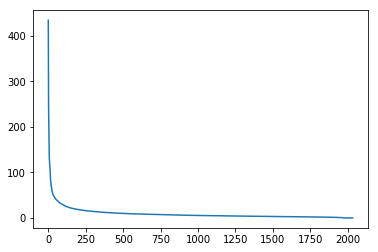

In [0]:
plt.plot(s)

To remind, the singular value is telling you the importance of topics. 

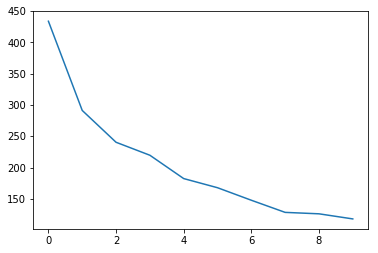

In [0]:
plt.plot(s[:10])

Note that other dimension is topics because we are doing topic modeling, you could be doing SVD on a different application. 

Here we will see what the topics. We create a function that go through the vocab and choose the largest values to be the top words for each topic. 

[42:14](https://youtu.be/tG3pUwmGjsc?t=2534)

[add excel pic]

Here each topic involves a liitle bit of every single word in the vocabulary. To get something meaningful out of this, we check out few words with the highest values here and assign those to be the words for the topic.


In [0]:
num_top_words = 8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words =([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [54]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

- 'ditto critus propagandist surname galacticentric kindergarten surreal imaginative' -> it seem we cannot what topic it is
- 'jpeg gif file color quality image jfif format' -> topic maybe regarding to graphic
- 'space nasa lunar mars probe moon missions probes', -> space 

We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an unsupervised algorithm - which is to say, we never actually told the algorithm how our documents are grouped.

We will return to SVD in much more detail later. For now, the important takeaway is that we have a tool that allows us to exactly factor a matrix into orthogonal columns and orthogonal rows.

#### Non-negative Matrix Factorization (NMF)

NMF is a different matrix factorization

##### Motivation of NMF 

What a negative values mean in a lots of context. People like NMF for its interpretability

This is looking at an image problem of decomposing faces into different components . This is also something  we call topics because we're doing topic modeling -> different components of the face

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/face_pca.png)

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

A more interpretable approach:

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/face_outputs.png)

##### Idea

Rather than constraining our factors to be orthogonal, another idea would to constrain them to be non-negative. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. **Often positive factors will be more easily interpretable** (and this is the reason behind NMF's popularity).

Data is often non-negative by nature

    • pixel intensities;
    • amplitude spectra;
    • occurrence counts;
    • food or energy consumption;
    • user scores;
    • stock market values;
    
For the sake of interpretability of the results, optimal processing of
nonnegative data may call for processing under nonnegativity
constraints.

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/face_nmf.png)

Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix. NMF is NP-hard and non-unique. There are a number of variations on it, created by adding different constraints.

##### Applications of NMF

- [Face Decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py)
- [Collaborative Filtering, eg movie recommendations](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)
- [Audio source separation](https://pdfs.semanticscholar.org/cc88/0b24791349df39c5d9b8c352911a0417df34.pdf)
- [Chemistry](http://ieeexplore.ieee.org/document/1532909/)
- [Bioinformatics](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0485-4) and [Gene Expression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2623306/)
- Topic Modeling (our problem!)

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/nmf_doc.png)

More Reading:

   -[The Why and How of Nonnegative Matrix Factorization](https://arxiv.org/pdf/1401.5226.pdf)

##### NMF from sklearn

We will use scikit-learn's implementation of NMF:

In [0]:
m,n = vectors.shape
d =5 # num_topics


the number of topics is a hyperparameter which you have to guess and this is thing you might want to try different things.

**Question**: is there any metric or a graph to evaluate what the number of topics is good for the model?

   **Rachel:** This is hard because this is an unsupervised problem. Usually we dont have the grouth truth of what the truth topics are. So in this case, we don't know. In practice, if you are working on this type of problem, you want to do exploratory data analysis (EDA) to see how many topics does this look like to me, try and figure if these topics are reasonable together

In [0]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors) # return the first matrix W
H1 = clf.components_ # how to access the second matrix H

In [57]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

'jpeg image gif file color images format quality' -> graphic

 'edu graphics pub mail 128 ray ftp send' ->graphic
 
 'space launch satellite nasa commercial satellites year market' -> space
 
 'jesus god people matthew atheists does atheism said ->religion
 
 'image data available software processing ftp edu analysis' ->



#### TF-IDF

Topic Frequency-Inverse Document Frequency (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

In [0]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) #(documents, vocab)

In [64]:
newsgroups_train.data[10:20]

["a\n\nWhat about positional uncertainties in S-L 1993e?   I assume we know where\nand what Galileo is doing within a few meters.   But without the\nHGA,  don't we have to have some pretty good ideas, of where to look\nbefore imaging?  If the HGA was working,  they could slew around\nin near real time (Less speed of light delay).  But when they were\nimaging toutatis????  didn't someone have to get lucky on a guess to\nfind the first images?   \n\nAlso, I imagine S-L 1993e will be mostly a visual image.  so how will\nthat affect the other imaging missions.  with the LGA,  there is a real\ntight allocation of bandwidth.   It may be premature to hope for answers,\nbut I thought i'd throw it on the floor.",
 "I would like to program Tseng ET4000 to nonstandard 1024x768 mode by\nswitching to standard 1024x768 mode using BIOS and than changing some\ntiming details (0x3D4 registers 0x00-0x1F) but I don't know how to\nselect 36 MHz pixel clock I need. The BIOS function selects 40 MHz.\n\nIs t

In [0]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [60]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

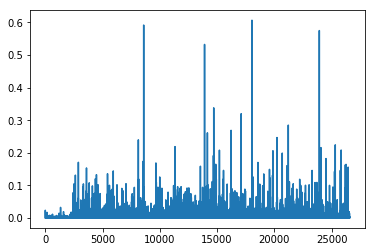

In [61]:
plt.plot(clf.components_[0])

There is something to note about NMF that when we reconstruct the vector , you may not get your original matrix back perfectly

In [63]:
clf.reconstruction_err_

43.712926057952785

#### NMF in summary

Benefits: Fast and easy to use!

Downsides: took years of research and expertise to create

Notes:

For NMF, matrix needs to be at least as tall as it is wide, or we get an error with fit_transform
Can use df_min in CountVectorizer to only look at words that were in at least k of the split texts

### Truncated SVD

We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD? Yes there is! It's called truncated SVD. We are just interested in the vectors corresponding to the largest singular values.

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/svd_fb.png)

(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

**Shortcomings of classical algorithms for decomposition:**

- Matrices are "stupendously big"
- Data are often **missing or inaccurate**. Why spend extra computational resources when imprecision of input limits precision of the output?
- **Data transfer** now plays a major role in time of algorithms. Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
Important to take advantage of **GPUs**.

(source: [Halko](https://arxiv.org/abs/0909.4061))

**Advantages of randomized algorithms**:

- inherently stable
- performance guarantees do not depend on subtle spectral properties
- needed matrix-vector products can be done in parallel

(source: [Halko](https://arxiv.org/abs/0909.4061))

## Time comparision

In [65]:
%time u,s,v = np.linalg.svd(vectors,full_matrices=False)

CPU times: user 1min 36s, sys: 5.28 s, total: 1min 41s
Wall time: 52.4 s


In [67]:
!pip install fbpca

  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
Successfully built fbpca


In [0]:
from sklearn import decomposition
import fbpca

In [70]:
%time u,s,v = decomposition.randomized_svd(vectors,10)

CPU times: user 8.26 s, sys: 1.71 s, total: 9.96 s
Wall time: 5.41 s


Randomized SVD from Facebook's library fbpca:

In [71]:
%time u,s,v = fbpca.pca(vectors,10)

CPU times: user 2.51 s, sys: 576 ms, total: 3.08 s
Wall time: 1.75 s


For more on randomized SVD, check out my [PyBay 2017 talk](https://www.youtube.com/watch?v=7i6kBz1kZ-A&list=PLtmWHNX-gukLQlMvtRJ19s7-8MrnRV6h6&index=7).

For significantly more on randomized SVD, check out the [Computational Linear Algebra course.](https://github.com/fastai/numerical-linear-algebra)

# Part 2: Review

[Video](https://youtu.be/lRZ4aMaXPBI?t=30)

## The two cultures

This "debate" captures the tension between two approaches:

- modeling the underlying mechanism of a phenomena
- using machine learning to predict outputs (without necessarily understanding the mechanisms that create them)

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/glutathione.jpg)


I was part of a research project (in 2007) that involved manually coding each of the above reactions. We were determining if the final system could generate the same ouputs (in this case, levels in the blood of various substrates) as were observed in clinical studies.

The equation for each reaction could be quite complex:

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/vcbs.png)

This is an example of modeling the underlying mechanism, and is very different from a machine learning approach.

Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2391141/



## stop words

**The most popular word in each state**

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/map-popular-word.png)

A time to remove stop words

## Factorization is analgous to matrix decomposition

We are using SVD and NMF to decompose the matrix and now we would like to provide a little bit more motivation of why that something we do.

First, we look at the simplest case

### with integers

Multiplication: $$2 * 2 * 3 * 3 * 2 * 2 \rightarrow 144$$

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/factorization.png)

Factorization is the “opposite” of multiplication: $$144 \rightarrow 2 * 2 * 3 * 3 * 2 * 2$$

Here, the factors have the nice property of being prime.

Prime factorization is much harder than multiplication (which is good, because it’s the heart of encryption).





### With Matrices

Matrix decompositions are a way of taking matrices apart (the "opposite" of matrix multiplication).

Similarly, we use matrix decompositions to come up with matrices with nice properties.

Taking matrices apart is harder than putting them together.

[One application](https://github.com/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb):

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/grid1.jpg)

What are the nice properties that matrices in an SVD decomposition have?

$$A = USV$$

## Some Linear Algebra Review

**Matrix-vector multiplication**

$Ax = b$ takes a linear combination of the columns of $A$, using coefficients $x$

http://matrixmultiplication.xyz/

**Matrix-matrix multiplication**

$A B = C$ each column of C is a linear combination of columns of A, where the coefficients come from the corresponding column of C

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/face_nmf.png)

**Matrices as Transformations**

The 3Blue 1Brown [Essence of Linear Algebra](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab) videos are fantastic. They give a much more visual & geometric perspective on linear algreba than how it is typically taught. These videos are a great resource if you are a linear algebra beginner, or feel uncomfortable or rusty with the material.

Even if you are a linear algrebra pro, I still recommend these videos for a new perspective, and they are very well made.

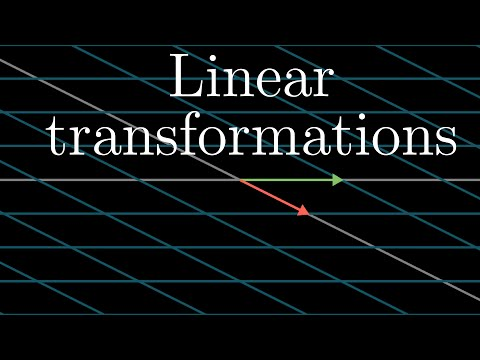

In [72]:
from IPython.display import YouTubeVideo

YouTubeVideo("kYB8IZa5AuE")

##British Literature SVD & NMF in Excel

Data was downloaded from [here](https://de.dariah.eu/tatom/datasets.html)

The code below was used to create the matrices which are displayed in the SVD and NMF of British Literature excel workbook. The data is intended to be viewed in Excel, I've just included the code here for thoroughness.

In [0]:
from glob import glob
import os

In [74]:
!wget https://liferay.de.dariah.eu/tatom/_downloads/datasets.zip

--2019-07-14 09:24:25--  https://liferay.de.dariah.eu/tatom/_downloads/datasets.zip
Resolving liferay.de.dariah.eu (liferay.de.dariah.eu)... 134.76.30.131
Connecting to liferay.de.dariah.eu (liferay.de.dariah.eu)|134.76.30.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57659024 (55M) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>]  54.99M  11.4MB/s    in 5.6s    

2019-07-14 09:24:31 (9.78 MB/s) - ‘datasets.zip’ saved [57659024/57659024]



In [0]:
os.makedirs('data/literature',exist_ok=True)
!unzip -qq /content/datasets.zip -d data/literature/

### Initializing, create document-term matrix

In [0]:
filenames = []
for folder in ["british-fiction-corpus"]: #, "french-plays", "hugo-les-misérables"]:
    filenames.extend(glob("data/literature/data/" + folder + "/*.txt"))

In [91]:
filenames[:5]

['data/literature/data/british-fiction-corpus/Trollope_Barchester.txt',
 'data/literature/data/british-fiction-corpus/Thackeray_Barry.txt',
 'data/literature/data/british-fiction-corpus/Eliot_Mill.txt',
 'data/literature/data/british-fiction-corpus/Austen_Pride.txt',
 'data/literature/data/british-fiction-corpus/EBronte_Wuthering.txt']

In [86]:
len(filenames)

27

In [89]:
vectorizer = TfidfVectorizer(input='filename',stop_words='english')
dtm = vectorizer.fit_transform(filenames).toarray()
vocab = np.array(vectorizer.get_feature_names())
dtm.shape,vocab.shape

((27, 55035), (55035,))

In [92]:
[f.split('/')[4] for f in filenames]    

['Trollope_Barchester.txt',
 'Thackeray_Barry.txt',
 'Eliot_Mill.txt',
 'Austen_Pride.txt',
 'EBronte_Wuthering.txt',
 'Sterne_Tristram.txt',
 'Richardson_Pamela.txt',
 'ABronte_Tenant.txt',
 'ABronte_Agnes.txt',
 'CBronte_Jane.txt',
 'CBronte_Villette.txt',
 'Austen_Emma.txt',
 'Dickens_Hard.txt',
 'Eliot_Middlemarch.txt',
 'Trollope_Prime.txt',
 'Fielding_Joseph.txt',
 'Dickens_Bleak.txt',
 'Sterne_Sentimental.txt',
 'Dickens_David.txt',
 'Eliot_Adam.txt',
 'Fielding_Tom.txt',
 'CBronte_Professor.txt',
 'Richardson_Clarissa.txt',
 'Thackeray_Pendennis.txt',
 'Trollope_Phineas.txt',
 'Thackeray_Vanity.txt',
 'Austen_Sense.txt']

### NFM



In [0]:
clf = decomposition.NMF(n_components=10,random_state=1)

W1 = clf.fit_transform(dtm)
H1 = clf.components_

In [0]:
num_top_words = 8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [0]:
def get_all_topic_words(H):
    top_indices = lambda t: {i for i in np.argsort(t)[:-num_top_words-1:-1]}
    topic_indices = [top_indices(t) for t in H]
    return sorted(set.union(*topic_indices))
    

In [0]:
ind = get_all_topic_words(H1)

In [99]:
vocab[ind]

array(['adams', 'allworthy', 'bounderby', 'brandon', 'catherine', 'cathy',
       'corporal', 'crawley', 'darcy', 'dashwood', 'did', 'earnshaw',
       'edgar', 'elinor', 'emma', 'father', 'ferrars', 'finn', 'glegg',
       'good', 'gradgrind', 'hareton', 'heathcliff', 'jennings', 'jones',
       'joseph', 'know', 'lady', 'laura', 'like', 'linton', 'little',
       'll', 'lopez', 'louisa', 'lyndon', 'maggie', 'man', 'marianne',
       'miss', 'mr', 'mrs', 'old', 'osborne', 'pendennis', 'philip',
       'phineas', 'quoth', 'said', 'sissy', 'sophia', 'sparsit',
       'stephen', 'thought', 'time', 'tis', 'toby', 'tom', 'trim',
       'tulliver', 'uncle', 'wakem', 'wharton', 'willoughby'],
      dtype='<U31')

In [100]:
show_topics(H1)

['mr said mrs miss emma darcy little know',
 'said little like did time know thought good',
 'adams jones said lady allworthy sophia joseph mr',
 'elinor marianne dashwood jennings willoughby mrs brandon ferrars',
 'toby said uncle father corporal quoth tis trim',
 'heathcliff linton hareton catherine earnshaw cathy edgar ll',
 'maggie tulliver said tom glegg philip mr wakem',
 'phineas said mr lopez finn man wharton laura',
 'said crawley lyndon pendennis old little osborne lady',
 'bounderby gradgrind sparsit said mr sissy louisa stephen']

#### Export to CSV


In [0]:
from IPython.display import FileLink, FileLinks

In [102]:
np.savetxt("britlit_W.csv", W1, delimiter=",", fmt='%.14f')
FileLink('britlit_W.csv')

/content/britlit_W.csv

In [104]:
np.savetxt("britlit_H.csv", H1[:,ind], delimiter=",", fmt='%.14f')
FileLink('britlit_H.csv')

/content/britlit_H.csv

In [105]:
np.savetxt("britlit_raw.csv", dtm[:,ind], delimiter=",", fmt='%.14f')
FileLink('britlit_raw.csv')

/content/britlit_raw.csv

In [106]:
[str(word) for word in vocab[ind]]

['adams',
 'allworthy',
 'bounderby',
 'brandon',
 'catherine',
 'cathy',
 'corporal',
 'crawley',
 'darcy',
 'dashwood',
 'did',
 'earnshaw',
 'edgar',
 'elinor',
 'emma',
 'father',
 'ferrars',
 'finn',
 'glegg',
 'good',
 'gradgrind',
 'hareton',
 'heathcliff',
 'jennings',
 'jones',
 'joseph',
 'know',
 'lady',
 'laura',
 'like',
 'linton',
 'little',
 'll',
 'lopez',
 'louisa',
 'lyndon',
 'maggie',
 'man',
 'marianne',
 'miss',
 'mr',
 'mrs',
 'old',
 'osborne',
 'pendennis',
 'philip',
 'phineas',
 'quoth',
 'said',
 'sissy',
 'sophia',
 'sparsit',
 'stephen',
 'thought',
 'time',
 'tis',
 'toby',
 'tom',
 'trim',
 'tulliver',
 'uncle',
 'wakem',
 'wharton',
 'willoughby']

### SVD

In [0]:
U , s, V = decomposition.randomized_svd(dtm,10)

In [0]:
ind = get_all_topic_words(H1)

In [109]:
len(ind)

64

In [110]:
vocab[ind]

array(['adams', 'allworthy', 'bounderby', 'brandon', 'catherine', 'cathy',
       'corporal', 'crawley', 'darcy', 'dashwood', 'did', 'earnshaw',
       'edgar', 'elinor', 'emma', 'father', 'ferrars', 'finn', 'glegg',
       'good', 'gradgrind', 'hareton', 'heathcliff', 'jennings', 'jones',
       'joseph', 'know', 'lady', 'laura', 'like', 'linton', 'little',
       'll', 'lopez', 'louisa', 'lyndon', 'maggie', 'man', 'marianne',
       'miss', 'mr', 'mrs', 'old', 'osborne', 'pendennis', 'philip',
       'phineas', 'quoth', 'said', 'sissy', 'sophia', 'sparsit',
       'stephen', 'thought', 'time', 'tis', 'toby', 'tom', 'trim',
       'tulliver', 'uncle', 'wakem', 'wharton', 'willoughby'],
      dtype='<U31')

In [111]:
show_topics(H1)

['mr said mrs miss emma darcy little know',
 'said little like did time know thought good',
 'adams jones said lady allworthy sophia joseph mr',
 'elinor marianne dashwood jennings willoughby mrs brandon ferrars',
 'toby said uncle father corporal quoth tis trim',
 'heathcliff linton hareton catherine earnshaw cathy edgar ll',
 'maggie tulliver said tom glegg philip mr wakem',
 'phineas said mr lopez finn man wharton laura',
 'said crawley lyndon pendennis old little osborne lady',
 'bounderby gradgrind sparsit said mr sissy louisa stephen']

In [112]:
np.savetxt("britlit_U.csv", U, delimiter=",", fmt='%.14f')
FileLink('britlit_U.csv')

/content/britlit_U.csv

In [113]:
np.savetxt("britlit_V.csv", V[:,ind], delimiter=",", fmt='%.14f')
FileLink('britlit_V.csv')

/content/britlit_V.csv

In [114]:
np.savetxt("britlit_raw_svd.csv", dtm[:,ind], delimiter=",", fmt='%.14f')
FileLink('britlit_raw_svd.csv')

/content/britlit_raw_svd.csv

In [115]:
np.savetxt("britlit_S.csv", np.diag(s), delimiter=",", fmt='%.14f')
FileLink('britlit_S.csv')

/content/britlit_S.csv

In [116]:
[str(word) for word in vocab[ind]]

['adams',
 'allworthy',
 'bounderby',
 'brandon',
 'catherine',
 'cathy',
 'corporal',
 'crawley',
 'darcy',
 'dashwood',
 'did',
 'earnshaw',
 'edgar',
 'elinor',
 'emma',
 'father',
 'ferrars',
 'finn',
 'glegg',
 'good',
 'gradgrind',
 'hareton',
 'heathcliff',
 'jennings',
 'jones',
 'joseph',
 'know',
 'lady',
 'laura',
 'like',
 'linton',
 'little',
 'll',
 'lopez',
 'louisa',
 'lyndon',
 'maggie',
 'man',
 'marianne',
 'miss',
 'mr',
 'mrs',
 'old',
 'osborne',
 'pendennis',
 'philip',
 'phineas',
 'quoth',
 'said',
 'sissy',
 'sophia',
 'sparsit',
 'stephen',
 'thought',
 'time',
 'tis',
 'toby',
 'tom',
 'trim',
 'tulliver',
 'uncle',
 'wakem',
 'wharton',
 'willoughby']

## Randomized SVD offers a speed up

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/svd_slow.png)

One way to address this is to use randomized SVD. In the below chart, the error is the difference between A - U S V, that is, what you've failed to capture in your decomposition:

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/svd_speed.png)



## Full vs Reduced SVD

Remember how we were calling **np.linalg.svd(vectors, full_matrices=False)**? We set **full_matrices=False** to calculate the reduced SVD. For the full SVD, both U and V are square matrices, where the extra columns in U form an orthonormal basis (but zero out when multiplied by extra rows of zeros in S).

Diagrams from Trefethen:

![alt text](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/full_svd.JPG)